# Mesh morphing with pyssam

This example visualises how pyssam can be used to visualise SSM modes of variance as a surface.

On this dataset, and definitely more real-world datasets, the results of the morphing will be **highly dependent** on the quality of the template. If the results are not satisfactory, simply use a template which is more similar to the target.

In [124]:
import pyssam

In [125]:
from copy import copy
import matplotlib.pyplot as plt
import numpy as np
import vedo as v

First, we source landmark data to use in our shape model

In [126]:
N_SAMPLES = 50
torus = pyssam.datasets.Torus()
torus_data = torus.make_dataset(N_SAMPLES)
landmark_coordinates = np.array([torus_i.points() for torus_i in torus_data])
# landmark_coordinates -= landmark_coordinates.mean(axis=0)

## Initialising the model

Here we convert to landmark coordinates into a parameterised shape model. We first initialise the class, which handles all pre-processing. Then, we can compute the shape model components and mean population shape

In [127]:
# if USE_SCALED_DATA = True, we should have 1 mode. If False, we should have 2 modes.
USE_SCALED_DATA = True

ssm_obj = pyssam.SSM(landmark_coordinates)
if USE_SCALED_DATA:
    ssm_obj.create_pca_model(ssm_obj.landmarks_columns_scale)
else:
    ssm_obj.create_pca_model(landmark_coordinates.reshape(N_SAMPLES, -1))
mean_shape_columnvector = ssm_obj.compute_dataset_mean()
mean_shape = mean_shape_columnvector.reshape(-1, 3)
shape_model_components = ssm_obj.pca_model_components

/Users/josh.williams/gitrepos/pyssam_morphing/pyssam/statistical_model_base.py:331: UserWarning: Dataset mean should be 0, is equal to [-6.2793369e-08  1.3605231e-07  4.1862247e-08  1.8314734e-07
  1.6483260e-07 -1.7268177e-07  1.6221621e-07  2.0931124e-08
  1.3081952e-08 -3.3489798e-07 -1.7791454e-07 -3.9245858e-08
 -2.8780295e-08  3.5059631e-07  1.2297035e-07  1.4390147e-07
  2.6163905e-08  2.3547514e-08  5.7560591e-08 -2.3024236e-07
  8.1108105e-08  7.0642542e-08  1.1773757e-07 -9.1573668e-08
 -6.0176980e-08 -2.5902264e-07  2.1716041e-07 -2.3285875e-07
  1.3605231e-07  7.0642542e-08 -2.7995378e-07  2.6163903e-07
  1.4651786e-07 -6.8026154e-08  1.9361289e-07  6.8026154e-08
 -2.3547514e-08 -3.6629466e-08  7.8491716e-08 -7.5875320e-08
 -2.0931124e-08 -2.1454402e-07  2.4855709e-07 -2.8780295e-08
 -1.4390147e-07 -1.0465562e-07 -2.8780295e-08 -1.5436703e-07
 -2.8780295e-07 -2.1716041e-07]
  warn("Dataset mean should be 0, " f"is equal to {dataset.mean(axis=1)}")


## Plotting and analysis

In [128]:
# Define some plotting functions

def plot_cumulative_variance(explained_variance, target_variance=-1):
    number_of_components = np.arange(0, len(explained_variance))+1
    fig, ax = plt.subplots(1,1)
    color = "blue"
    ax.plot(number_of_components, explained_variance*100.0, marker="o", ms=2, color=color, mec=color, mfc=color)
    if target_variance > 0.0:
        ax.axhline(target_variance*100.0)
    
    ax.set_ylabel("Variance [%]")
    ax.set_xlabel("Number of components")
    ax.grid(axis="x")
    plt.show()
    
def plot_shape_modes(
  mean_shape_columnvector, 
  mean_shape, 
  original_shape_parameter_vector,
  shape_model_components,
  mode_to_plot,
):
  weights = [-2, 0, 2]
  fig, ax = plt.subplots(1, 3, figsize=(10, 4))
  x_min, x_max, y_min, y_max = np.inf, -np.inf, np.inf, -np.inf
  mode_outputs = []
  for j, weights_i in enumerate(weights):
    shape_parameter_vector = copy(original_shape_parameter_vector)
    shape_parameter_vector[mode_to_plot] = weights_i
    mode_i_coords = ssm_obj.morph_model(
        mean_shape_columnvector, 
        shape_model_components, 
        shape_parameter_vector
    ).reshape(-1, 3)
    print(mode_i_coords.min(axis=0), mode_i_coords.max(axis=0))

    offset_dist = pyssam.utils.euclidean_distance(
      mean_shape, 
      mode_i_coords
    )
    # colour points blue if closer to point cloud centre than mean shape
    mean_shape_dist_from_centre = pyssam.utils.euclidean_distance(
      mean_shape,
      np.zeros(3),
    )
    mode_i_dist_from_centre = pyssam.utils.euclidean_distance(
      mode_i_coords,
      np.zeros(3),
    )
    offset_dist = np.where(
        mode_i_dist_from_centre<mean_shape_dist_from_centre,
        offset_dist*-1,
        offset_dist,
    )
    if weights_i == 0:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 1],
        c="gray",
        s=1,
      )
      ax[j].set_title("mean shape")
    else:
      ax[j].scatter(
        mode_i_coords[:, 0],
        mode_i_coords[:, 1],
        c=offset_dist,
        cmap="seismic",
        vmin=-1,
        vmax=1,
        s=1,
      )
      ax[j].set_title(f"mode {mode_to_plot} \nweight {weights_i}")
    mode_outputs.append(mode_i_coords)
    if mode_i_coords[:,0].min() < x_min:
        x_min = mode_i_coords[:,0].min()
    if mode_i_coords[:,1].min() < y_min:
        y_min = mode_i_coords[:,1].min()
    if mode_i_coords[:,0].max() > x_max:
        x_max = mode_i_coords[:,0].max()
    if mode_i_coords[:,1].max() > y_max:
        y_max = mode_i_coords[:,1].max()
    ax[j].axis('off')
    ax[j].margins(0,0)
    ax[j].xaxis.set_major_locator(plt.NullLocator())
    ax[j].yaxis.set_major_locator(plt.NullLocator())

  for j, weights_i in enumerate(weights):
    ax[j].set_xlim([x_min, x_max])
    ax[j].set_ylim([y_min, y_max])
  plt.show()
  return mode_outputs

To check how different the shapes we are dealing with are, we first visualise the modes as point cloud from pyssam.

explained variance is 0.9900384545326233
[-2.5016487  -2.51368297 -1.14551056] [2.50164867 2.48907479 1.14551056]
[-2.2493391  -2.26309896 -0.70379257] [2.2493391  2.23509407 0.70379257]
[-1.99702951 -2.01251494 -0.26207458] [1.99702954 1.98111369 0.26207458]


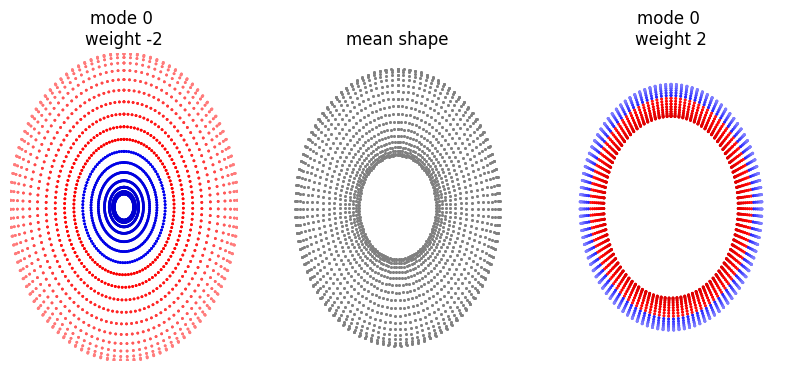

In [129]:
mode_to_plot = 0
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

mode_outputs = plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
    mode_to_plot,
)

If the variable `USE_SCALED_DATA` above is true, the following should show essentially no variation.

explained variance is 0.009961527772247791
[-2.31098997 -2.32514025 -0.72158979] [2.31098996 2.29635696 0.72158979]
[-2.2493391  -2.26309896 -0.70379257] [2.2493391  2.23509407 0.70379257]
[-2.18768823 -2.20105766 -0.68599535] [2.18768825 2.17384694 0.68599535]


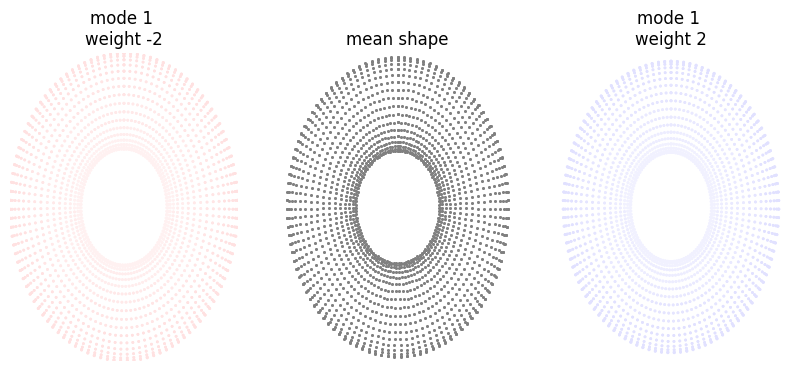

[array([[-1.07056462e-04,  2.29635696e+00, -2.66629262e-08],
        [ 1.48430922e-09,  2.28473309e+00,  1.28974730e-01],
        [ 1.59584812e-09,  2.25028214e+00,  2.53804049e-01],
        ...,
        [ 1.61458277e-09,  2.25028214e+00, -2.53804080e-01],
        [ 1.61458343e-09,  2.28473309e+00, -1.28974717e-01],
        [ 1.61458277e-09,  2.29634120e+00, -3.35270294e-10]]),
 array([[ 8.49242188e-09,  2.23509407e+00,  2.31694552e-10],
        [ 8.49242188e-09,  2.22377229e+00,  1.25793710e-01],
        [ 8.49242188e-09,  2.19017100e+00,  2.47544244e-01],
        ...,
        [ 8.49238369e-09,  2.19017100e+00, -2.47544274e-01],
        [ 8.49238369e-09,  2.22377229e+00, -1.25793695e-01],
        [ 8.49238369e-09,  2.23509407e+00,  2.31694344e-10]]),
 array([[ 1.07073447e-04,  2.17383118e+00,  2.71263153e-08],
        [ 1.55005345e-08,  2.16281148e+00,  1.22612691e-01],
        [ 1.53889956e-08,  2.13005987e+00,  2.41284439e-01],
        ...,
        [ 1.53701846e-08,  2.13005987e+00,

In [130]:
mode_to_plot = 1
print(f"explained variance is {ssm_obj.pca_object.explained_variance_ratio_[mode_to_plot]}")

plot_shape_modes(
    mean_shape_columnvector, 
    mean_shape, 
    ssm_obj.model_parameters,
    ssm_obj.pca_model_components,
    mode_to_plot,
)

The above plots are useful, but it is nicer to visualise the output as a surface.

## Mesh morphing

First, lets look at the template mesh and template landmarks (blue). We also show the *target* landmarks as black for comparison.

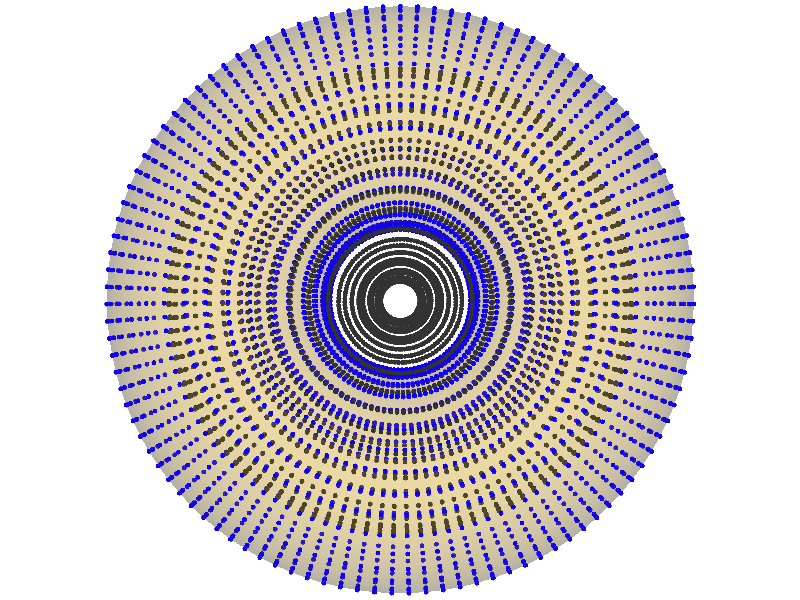

In [131]:
TEMPLATE_CASE = 0
landmark_target = mode_outputs[0]
mesh_template = torus_data[TEMPLATE_CASE]
landmark_template = landmark_coordinates[TEMPLATE_CASE]
v.show(mesh_template.alpha(0.2), v.Points(landmark_template, r=5, c="blue"), v.Points(landmark_target, r=5))

Now we will mesh the template to the target. We then will visualise the target mesh and landmarks.

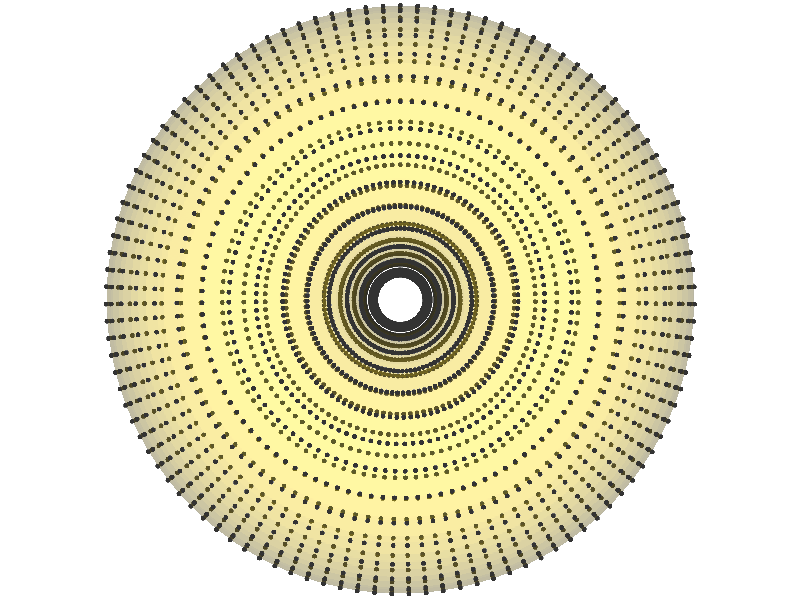

In [132]:
mesh_target_i = pyssam.morph_mesh.MorphTemplateMesh(landmark_target, landmark_coordinates[TEMPLATE_CASE], torus_data[TEMPLATE_CASE]).mesh_target
v.show(mesh_target_i.alpha(0.2), v.Points(landmark_target, r=5))